# GF($2^m$) Multiplication

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `GF2Multiplication`
Out of place multiplication over GF($2^m$).

The bloq implements out of place multiplication of two quantum registers storing elements
from GF($2^m$) using construction described in Ref[1], which extends the classical construction
of Ref[2].

To multiply two m-bit inputs $a = [a_0, a_1, ..., a_{m-1}]$ and $b = [b_0, b_1, ..., b_{m-1}]$,
the construction computes the output vector $c$ via the following three steps:
    1. Compute $e = U.b$ where $U$ is an upper triangular matrix constructed using $a$.
    2. Compute $Q.e$ where $Q$ is an $m \times (m - 1)$ reduction matrix that depends upon the
        irreducible polynomial $P(x)$ of the galois field $GF(2^m)$. The i'th column of the
        matrix corresponds to coefficients of the polynomial $x^{m + i} % P(x)$. This matrix $Q$
        is a linear reversible circuit that can be implemented only using CNOT gates.
    3. Compute $d = L.b$ where $L$ is a lower triangular matrix constructed using $a$.
    4. Compute $c = d + Q.e$ to obtain the final product.

Steps 1 and 3 are performed using $n^2$ Toffoli gates and step 2 is performed only using CNOT
gates.

#### Parameters
 - `bitsize`: The degree $m$ of the galois field $GF(2^m)$. Also corresponds to the number of qubits in each of the two input registers $a$ and $b$ that should be multiplied.
 - `plus_equal_prod`: If True, implements the `PlusEqualProduct` version that applies the map $|x\rangle |y\rangle |z\rangle \rightarrow |x\rangle |y\rangle |x + z\rangle$. 

#### Registers
 - `x`: Input THRU register of size $m$ that stores elements from $GF(2^m)$.
 - `y`: Input THRU register of size $m$ that stores elements from $GF(2^m)$.
 - `result`: Register of size $m$ that stores the product $x * y$ in $GF(2^m)$. If plus_equal_prod is True - result is a THRU register and stores $result + x * y$. If plus_equal_prod is False - result is a RIGHT register and stores $x * y$.  

#### References
 - [On the Design and Optimization of a Quantum Polynomial-Time Attack on Elliptic Curve Cryptography](https://arxiv.org/abs/0710.1093). 
 - [Low complexity bit parallel architectures for polynomial basis multiplication over GF(2m)](https://ieeexplore.ieee.org/abstract/document/1306989). 


In [2]:
from qualtran.bloqs.gf_arithmetic import GF2Multiplication

### Example Instances

In [3]:
gf16_multiplication = GF2Multiplication(4, plus_equal_prod=True)

In [4]:
import sympy

m = sympy.Symbol('m')
gf2_multiplication_symbolic = GF2Multiplication(m, plus_equal_prod=False)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([gf16_multiplication, gf2_multiplication_symbolic],
           ['`gf16_multiplication`', '`gf2_multiplication_symbolic`'])

### Call Graph

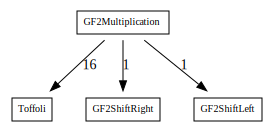

#### Counts totals:
 - `GF2ShiftLeft`: 1
 - `GF2ShiftRight`: 1
 - `Toffoli`: 16

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
gf16_multiplication_g, gf16_multiplication_sigma = gf16_multiplication.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(gf16_multiplication_g)
show_counts_sigma(gf16_multiplication_sigma)

## `GF2MulK`
Multiply by constant $f(x)$ modulo $m(x)$. Both $f(x)$ and $m(x)$ are constants.

#### Parameters
 - `const`: The multiplication constant which is an element of the given field.
 - `galois_field`: The galois field that defines the arithmetics. 

#### Registers
 - `g`: The polynomial coefficients (in GF(2)). 

#### References
 - [Space-efficient quantum multiplication of polynomials for binary finite fields with     sub-quadratic Toffoli gate count](https://arxiv.org/abs/1910.02849v2). Algorithm 1


In [7]:
from qualtran.bloqs.gf_arithmetic import GF2MulK

### Example Instances

In [8]:
import galois

from qualtran import QGF

mx = galois.Poly.Degrees([0, 1, 3])  # x^3 + x + 1
gf = galois.GF(2, 3, irreducible_poly=mx)
const = 5  # x^2 + 1
gf2_multiply_by_constant = GF2MulK(QGF(2, 3, mx), const)

In [9]:
fx = [2, 0]  # x^2 + 1
mx = [0, 1, 3]  # x^3 + x + 1
gf2_poly_multiply_by_constant = GF2MulK.from_polynomials(fx, mx)

#### Graphical Signature

In [10]:
from qualtran.drawing import show_bloqs
show_bloqs([gf2_multiply_by_constant, gf2_poly_multiply_by_constant],
           ['`gf2_multiply_by_constant`', '`gf2_poly_multiply_by_constant`'])

### Call Graph

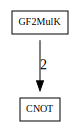

#### Counts totals:
 - `CNOT`: 2

In [11]:
from qualtran.resource_counting.generalizers import ignore_split_join
gf2_multiply_by_constant_g, gf2_multiply_by_constant_sigma = gf2_multiply_by_constant.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(gf2_multiply_by_constant_g)
show_counts_sigma(gf2_multiply_by_constant_sigma)

## `MultiplyPolyByOnePlusXk`
Out of place multiplication of $(1 + x^k) fg$

Applies the transformation
$$
\ket{f}\ket{g}\ket{h} \rightarrow \ket{f}{\ket{g}}\ket{h \oplus (1+x^k)fg}
$$

Note: While this construction follows Algorithm2 of https://arxiv.org/abs/1910.02849v2,
it has a slight modification. Namely that the original construction doesn't work in
some cases where $k < n$. However reversing the order of the first set of CNOTs (line 2)
makes the construction work for all $k \leq n+1$.

#### Parameters
 - `n`: The degree of the polynomial ($2^n$ is the size of the galois field).
 - `k`: An integer specifing the shift $1 + x^k$ (or $1 + 2^k$ for galois fields.) 

#### Registers
 - `f`: The first polynomial.
 - `g`: The second polyonmial.
 - `h`: The target polynomial. 

#### References
 - [Space-efficient quantum multiplication of polynomials for binary finite fields with     sub-quadratic Toffoli gate count](https://arxiv.org/abs/1910.02849v2). Algorithm 2


In [12]:
from qualtran.bloqs.gf_arithmetic import MultiplyPolyByOnePlusXk

### Example Instances

In [13]:
n = 5
k = 3
multiplypolybyoneplusxk = MultiplyPolyByOnePlusXk(n, k)

#### Graphical Signature

In [14]:
from qualtran.drawing import show_bloqs
show_bloqs([multiplypolybyoneplusxk],
           ['`multiplypolybyoneplusxk`'])

### Call Graph

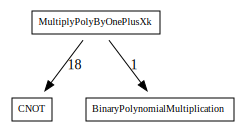

#### Counts totals:
 - `BinaryPolynomialMultiplication`: 1
 - `CNOT`: 18

In [15]:
from qualtran.resource_counting.generalizers import ignore_split_join
multiplypolybyoneplusxk_g, multiplypolybyoneplusxk_sigma = multiplypolybyoneplusxk.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(multiplypolybyoneplusxk_g)
show_counts_sigma(multiplypolybyoneplusxk_sigma)

## `BinaryPolynomialMultiplication`
Out of place multiplication of binary polynomial multiplication.

Applies the transformation
$$
\ket{f}\ket{g}\ket{h} \rightarrow \ket{f}{\ket{g}}\ket{h \oplus fg}
$$

The toffoli cost of this construction is $n^{\log_2{3}}$, while CNOT count is
upper bounded by $(10 + \frac{1}{3}) n^{\log_2{3}}$.

#### Parameters
 - `n`: The degree of the polynomial ($2^n$ is the size of the galois field). 

#### Registers
 - `f`: The first polynomial.
 - `g`: The second polyonmial.
 - `h`: The target polynomial. 

#### References
 - [Space-efficient quantum multiplication of polynomials for binary finite fields with     sub-quadratic Toffoli gate count](https://arxiv.org/abs/1910.02849v2). Algorithm 3


In [16]:
from qualtran.bloqs.gf_arithmetic import BinaryPolynomialMultiplication

### Example Instances

In [17]:
n = 5
binarypolynomialmultiplication = BinaryPolynomialMultiplication(n)

#### Graphical Signature

In [18]:
from qualtran.drawing import show_bloqs
show_bloqs([binarypolynomialmultiplication],
           ['`binarypolynomialmultiplication`'])

### Call Graph

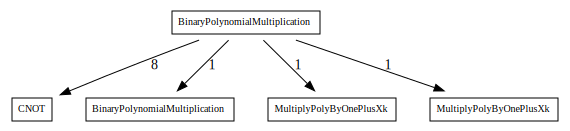

#### Counts totals:
 - `BinaryPolynomialMultiplication`: 1
 - `CNOT`: 8
 - `MultiplyPolyByOnePlusXk`: 1
 - `MultiplyPolyByOnePlusXk`: 1

In [19]:
from qualtran.resource_counting.generalizers import ignore_split_join
binarypolynomialmultiplication_g, binarypolynomialmultiplication_sigma = binarypolynomialmultiplication.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(binarypolynomialmultiplication_g)
show_counts_sigma(binarypolynomialmultiplication_sigma)

## `GF2ShiftRight`
Multiplies by $2^k$ (or $x^k$ for polynomials) modulo the given irreducible polynomial.

Applies the transformation
$$
    \ket{f} \rightarrow \ket{x^k f \mod m(x)}
$$

Where the modulus $m(x)$ is the irreducible polynomial defining the galois field arithmetic.

#### Parameters
 - `m_x`: The irreducible polynomial that defines the galois field.
 - `k`: The number of shifts (i.e. the exponent of $2$ or $x$). 

#### Registers
 - `f`: The number (polynomial) to shift. 

#### References
 - [Space-efficient quantum multiplication of polynomials for binary finite fields with     sub-quadratic Toffoli gate count](https://arxiv.org/abs/1910.02849v2). Section 3.1


In [20]:
from qualtran.bloqs.gf_arithmetic import GF2ShiftRight

### Example Instances

In [21]:
m_x = [5, 2, 0]  # x^5 + x^2 + 1
gf2shiftright = GF2ShiftRight(QGF(2, 5, m_x), k=3)  # shift by 3

#### Graphical Signature

In [22]:
from qualtran.drawing import show_bloqs
show_bloqs([gf2shiftright],
           ['`gf2shiftright`'])

### Call Graph

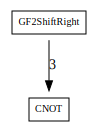

#### Counts totals:
 - `CNOT`: 3

In [23]:
from qualtran.resource_counting.generalizers import ignore_split_join
gf2shiftright_g, gf2shiftright_sigma = gf2shiftright.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(gf2shiftright_g)
show_counts_sigma(gf2shiftright_sigma)

## `GF2MulViaKaratsuba`
Multiplies two GF($2^n$) numbers (or binary polynomials) modulo $m(x)$.

Applies the transformation
$$
    \ket{f}\ket{g} \rightarrow \ket{f} \ket{g} \ket{f*g \mod m(x)}
$$

Where the modulus $m(x)$ is the irreducible polynomial defining the galois field arithmetic.
The toffoli complexity is $n^{\log_2{3}}$

#### Parameters
 - `m_x`: The irreducible polynomial that defines the galois field.
 - `uncompute`: Whether to compute or uncompute the product. 

#### Registers
 - `x`: A TRHU register representing the first number (or polynomial).
 - `y`: A TRHU register representing the second number (polynomial).
 - `result`: The result (a RIGHT register). 

#### References
 - [Space-efficient quantum multiplication of polynomials for binary finite fields with     sub-quadratic Toffoli gate count](https://arxiv.org/abs/1910.02849v2). Algorithm 4.


In [24]:
from qualtran.bloqs.gf_arithmetic import GF2MulViaKaratsuba

### Example Instances

In [25]:
m_x = [5, 2, 0]  # x^5 + x^2 + 1
gf2mulviakaratsuba = GF2MulViaKaratsuba(QGF(2, 5, m_x))

#### Graphical Signature

In [26]:
from qualtran.drawing import show_bloqs
show_bloqs([gf2mulviakaratsuba],
           ['`gf2mulviakaratsuba`'])

### Call Graph

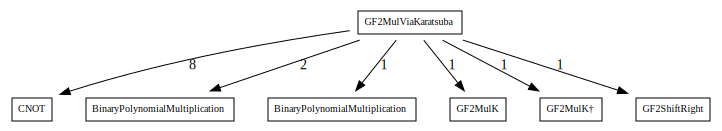

#### Counts totals:
 - `BinaryPolynomialMultiplication`: 1
 - `BinaryPolynomialMultiplication`: 2
 - `CNOT`: 8
 - `GF2MulK`: 1
 - `GF2MulK†`: 1
 - `GF2ShiftRight`: 1

In [27]:
from qualtran.resource_counting.generalizers import ignore_split_join
gf2mulviakaratsuba_g, gf2mulviakaratsuba_sigma = gf2mulviakaratsuba.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(gf2mulviakaratsuba_g)
show_counts_sigma(gf2mulviakaratsuba_sigma)

## `GF2ShiftLeft`
Divides by $2^k$ (or $x^k$ for polynomials) modulo the given irreducible polynomial.

Applies the transformation
$$
    \ket{f} \rightarrow \ket{x^{-k} f \mod m(x)}
$$

Where the modulus $m(x)$ is the irreducible polynomial defining the galois field arithmetic.

#### Parameters
 - `m_x`: The irreducible polynomial that defines the galois field.
 - `k`: The number of shifts (i.e. the exponent of $2$ or $x$). 

#### Registers
 - `f`: The number (polynomial) to shift.


In [28]:
from qualtran.bloqs.gf_arithmetic import GF2ShiftLeft

### Example Instances

In [29]:
m_x = [5, 2, 0]  # x^5 + x^2 + 1
gf2shiftleft = GF2ShiftLeft(QGF(2, 5, m_x), k=3)  # shift by 3

#### Graphical Signature

In [30]:
from qualtran.drawing import show_bloqs
show_bloqs([gf2shiftleft],
           ['`gf2shiftleft`'])

### Call Graph

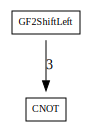

#### Counts totals:
 - `CNOT`: 3

In [31]:
from qualtran.resource_counting.generalizers import ignore_split_join
gf2shiftleft_g, gf2shiftleft_sigma = gf2shiftleft.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(gf2shiftleft_g)
show_counts_sigma(gf2shiftleft_sigma)